In [38]:
# Importing libraries
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib as mpl
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score,precision_recall_curve


### Classification problem

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### One line per instance and one column for each feature

In [3]:
X,y = mnist["data"],mnist["target"]
X.shape


### 70000 images with 784 features ( each image is 28x28 pixels )

(70000, 784)

In [4]:
y.shape

(70000,)

In [19]:
type(X)
X_numpy = X.to_numpy()

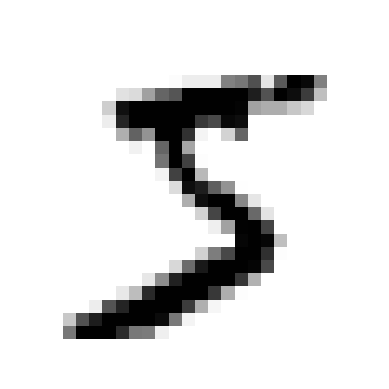

In [6]:
some_digit = X_numpy[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

plt.show()

### Looks like a 5, let`s check

In [7]:
y[0]

# This is a string , i need to convert into numbers 

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
y[0]

5

### Separate the train and test set before anything

In [10]:
# The training set of MNIST is already shuffled. The test set are the last 10000 images
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

### I should identify the digit

### For example , trying to identify number 5 would have 2 classes : 5 and not 5 

In [11]:
y_train_5 = (Y_train == 5) # True when the label is 5
y_test_5 = (Y_test == 5)   # True when label is 5 

### Now training with SGD ( stochastic gradient descent) because it can deal better with large datasets

In [12]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5) # Using all my train dataset , i want to see which are 5

# In order to keep reproducible results ,i need to put random_state 

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])
# Should be true

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures

## Cross-Validation

In [14]:
''' 

# Implementing cross-validation in order to have control over it 

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
# Splits equally in 3 (maintaing the ratio of the classes) and maintain the state to reproduce again

for train_index,test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # Clone the model

    # Track the values in train and test 
    # use a different index for train and test

    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_test[test_index]
    y_test_folds = y_test_5[test_index]

    # I am using the model to evaluate the division made by stratifiedkfold
    # So i can test with EACH division and see the result


    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

''' 

' \n\n# Implementing cross-validation in order to have control over it \n\nskfolds = StratifiedKFold(n_splits = 3, random_state = 42)\n# Splits equally in 3 (maintaing the ratio of the classes) and maintain the state to reproduce again\n\nfor train_index,test_index in skfolds.split(X_train, y_train_5):\n    clone_clf = clone(sgd_clf) # Clone the model\n\n    # Track the values in train and test \n    # use a different index for train and test\n\n    X_train_folds = X_train[train_index]\n    y_train_folds = y_train_5[train_index]\n    X_test_folds = X_test[test_index]\n    y_test_folds = y_test_5[test_index]\n\n    # I am using the model to evaluate the division made by stratifiedkfold\n    # So i can test with EACH division and see the result\n\n\n    clone_clf.fit(X_train_folds,y_train_folds)\n    y_pred = clone_clf.predict(X_test_folds)\n    n_correct = sum(y_pred == y_test_folds)\n    print(n_correct / len(y_pred))\n\n'

In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3 , scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

### A high accuracy, testing with a dumb classifier

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype = bool)

### Classifies every image in not-5 class

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 , scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

### High accuracy. only 10% of the images should be 5

### This is the reason why accuracy is not always a good measure . Specially in skewed datasets (some classes way more frequent)

## Confusion Matrix

### Count the number of times that class A is classified as class B

### Thus , to look how many times the classifier confused image of 5 with 3 , i look row 5 , column 3 

In [21]:
# These predictions will be compared to the actual target
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Does not return the evaluation scores, but the prediction for each test fold

In [23]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### what this means :

each row is the ACTUAL class   ( on this case the class used train_5)
each column is the PREDICTED class

First row -> Non 5 images
Second row -> 5 images

True Negatives False Positives 
False Negative True Positives

True and false when it got correct
Positive and false in accord of the class we are testing

In [25]:
y_train_perfect_predictions = y_train_5 # always see if it is 5 or not 
confusion_matrix(y_train_5,y_train_perfect_predictions)

# Only true Positives and true Negatives

array([[54579,     0],
       [    0,  5421]])

# I can look at the ACCURACY of the positive predictions. The precision of the classifier

Precision = TP/ TP + FP

from all positives (all classified as 5) , how many of them are really correctly classified?

does not matter how many are , just how many were indicated. so first i have to identify all the 5 and then i see how many i got right

This shows the trust in identifying my class

# Recall/ or sensitivity or True positive rate (TPR) helps with the info of accuracy

This is the ratio of positive instances that are correctly detected 

Recall = TP/ TP + FN

from all the 5 existents in the dataset , how many my model founded ? 

so if there were 100 images of 5 and my model only identified 10 , it has a recall of 10/100

it only gets how many number 5 were reached by the model !! 

this show the trust in finding , in my dataset, the class

In [27]:
precision_score(y_train_5,y_train_pred)

# Thus i have 83% of precision . From all the 5 that my model saw , it identified correctely 83%

0.8370879772350012

In [28]:
recall_score(y_train_5,y_train_pred)

# Hence i have 65% of recall . From all the 5 of my dataset ,my model only got 65% of them

0.6511713705958311

### Combining precision and recall in one metric is called F score
### It is the Harmonic mean of precision and recall because, while the 
### mean treats all numbers as equal, the harmonic gives more weight to lower values !!

### Thus , the F will have a high score only if both recall and precision are high

In [30]:
f1_score(y_train_5,y_train_pred)

0.7325171197343847

the f1 score favors classsifiers with SIMILAR precision and recall. 

But there are times i need more precision or recall. it is a tradeoff

In [31]:
# in order to set a threeshold i can use a decision function

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [36]:
threeshold = 0
y_some_digit_pred = (y_scores > threeshold)
y_some_digit_pred

array([ True])

In [35]:
threeshold = 8000
y_some_digit_pred = (y_scores> threeshold)
y_some_digit_pred

array([False])

raising the threeshold decreases recall

In [37]:
y_scores = cross_val_predict(sgd_clf,X_train , y_train_5 , cv=3 , method = 'decision_function')

### Now i can set the precision-recall curve to set my threeshold

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


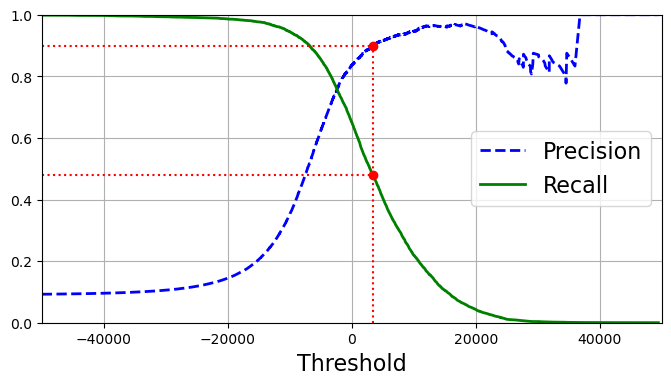

In [50]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()